## Caderno de código para o projeto "Building a Simple Information Retrieval System using BM25 and GPT-3 and evaluated in the CISI collection"

_Leandro Carísio Fernandes_


Este caderno de código foi desenvolvido para a pré-selecão da disciplina "Deep Learning aplicado a sistemas de buscas". Foi solicitado a implementação de um algoritmo BM25 e sua aplicação à coleção CISI. O uso do ChatGPT foi permitido e encorajado.

Algumas observações em relação para a execução deste caderno:

1. O caderno deve ser executado sequencialmente, pois algumas células dependem de variáveis definidas em células anteriores. 

2. A única biblioteca que pode não estar disponível numa instalação do Jupyter Notebook é a nltk. Caso não esteja disponível em seu ambiente, é necessária instalá-la antes. Apenas o objeto PorterStemmer desta biblioteca foi utilizado.

Este caderno é dividido em 7 seções:

[1. Função de suporte para ler os arquivos CISI](#1.-Função-de-suporte-para-ler-os-arquivos-CISI): Apresenta funções para leitura dos arquivos da coleção CISI e organização em dicionários

[2. Implementação do algoritmo BM25](#2.-Implementação-do-algoritmo-BM25): Aqui é feita a implementação do BM25 e do pré-processamento de texto (necessário tanta para a indexação dos documentos quanto para a query)

[3. Testando a implementação com 5 documentos simples em português](#3.-Testando-a-implementação-com-5-documentos-simples-em-português): Esta seção apresenta um caso de teste com 5 documentos simples, faz o cálculo manual do score e compara com o resultado do algoritmo implementado

[4. Aplicando o algoritmo na base do CISI](#4.-Aplicando-o-algoritmo-na-base-do-CISI): Compara o resultado do algoritmo com todas as queries que possuem documentos relevantes da base CISI

[5. Teste sua query na base CISI](#5.-Teste-sua-query-na-base-CISI:): Esta seção permite verificar o resultado de alguma query na coleção CISI e comparar com o resultado esperado. Também permite testar também queries que não estão na base de dados

[6. Usuando o ChatGPT](#6.-Usando-o-ChatGPT): Usa o ChatGPT para criar uma base de dados curta de testes e para fornecer uma implementação do algoritmo BM25, cujos resultados são comparados com a implementação da seção 2.

[7. Conclusões](#7.-Conclusões): Apresenta as conclusões deste trabalho

In [1]:
from collections import Counter
import numpy as np
import string
import math
import nltk
from operator import itemgetter
import re
import matplotlib.pyplot as plt

### 1. Função de suporte para ler os arquivos CISI

Os arquivos da base de dados CISI seguem um formato padronizado descrito no relatório associado a este notebook [relatorio]. Há, no Kagle, [código](https://www.kaggle.com/code/vabatista/introduction-to-information-retrieval/notebook) pronto para ler essa base de dados. Para não reinventar a roda, o código encontrado será usado como base, comentado e encapsulado numa função read_cisi_files que retornará uma tupla (doc, qry, rel) contendo o conjunto de documentos, o conjunto de queries, e o conjunto de relações queries-documentos. Os dados da tupla são:

- doc: um dicionário indexado pelo id do documento (inteiros de 1 a 1460). O retorno desse dicionário é um outro dicionário no formato {title: string, abstract: string, author: string, all: string}, onde o campo all é a concatenação dos outros campos
- qry: um dicionário indexado pelo id da query (inteiros de 1 a 112) e que retorna uma string contendo a query
- rel: um dicionário indexado pelo ida da query (não há dados para todas as queries) e que retorna uma lista contendo os documentos mais relevantes para a query

In [2]:
# Auxiliary function to convert keys of a dictionary
# Input: {".A": string, ".T": string, ".W": string}
# Output: {"author": string, "title": string, "abstract": string, "all": string}
def convert_doc(doc):
    converted_doc = {}
    converted_doc['author'] = doc['.A']
    converted_doc['title'] = doc['.T']
    converted_doc['abstract'] = doc['.W']
    converted_doc['all'] = f"{doc['.A']} {doc['.T']} {doc['.W']}"
    return converted_doc

# Read the file and return a list with its lines. Each line corresponds to one attribute.
# So, if the attribute (i.e. the abstract .W) is split in some lines, they are join
def get_lines_with_joint_tag_info(file):
    with open(file) as f:
        lines = ""
        for l in f.readlines():
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        lines = lines.lstrip("\n").split("\n")
    return lines

def read_cisi_files():  
    ###################################
    ######  Processing DOCUMENTS ###### 
    ###################################
    doc_set = {}
    doc_id = ""
   
    # Read cisi.all
    lines = get_lines_with_joint_tag_info('./cisi/CISI.ALL')

    # Iterate lines
    for line in lines:
        line = line.strip()

        reading_field = ""
        content = ""

        # All line should start with .
        if line.startswith("."):
            reading_field = line[0:2]
            content = line[3:].strip()
        else:
            # This is just a logic check
            print('Checking logic. This message should never appears')

        # If the line is the id, just get it. Otherwise, populate the doc
        if reading_field == ".I":
            doc_id = int(line[3:].strip())
        else:
            # If is the first time reading the doc from the dict, create an empty doc
            doc = doc_set.get(doc_id, {})

            # If the field already has a content (i.e. author), append the new content to the old one
            field_content = doc.get(reading_field, "")
            field_content = field_content + " " + content + " . "

            # Update doc            
            doc[reading_field] = field_content.strip()
            doc_set[doc_id] = doc
    doc_set = dict( (doc_id, convert_doc(doc_set[doc_id]))  for doc_id in doc_set.keys())

    #################################
    ######  Processing QUERIES ###### 
    #################################
    qry_set = {}
    qry_id = ""
    
    # Reade cisi.qry
    lines = get_lines_with_joint_tag_info('./cisi/CISI.QRY')
        
    for l in lines:
        if l.startswith(".I"):
            qry_id = int(l.split(" ")[1].strip())
        elif l.startswith(".W"):
            qry_set[qry_id] = l.strip()[3:]
            qry_id = ""
    
    #####################################################
    ######  Processing QUERY-DOCUMENT associations ###### 
    #####################################################
    rel_set = {}
    with open('./cisi/CISI.REL') as f:
        for l in f.readlines():
            qry_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0]) 
            doc_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1])
            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)

    return (doc_set, qry_set, rel_set)

doc_set, qry_set, rel_set = read_cisi_files()

### 2. Implementação do algoritmo BM25

Vamos criar um corpus que é uma classe que possui a seguinte estrutura:

```python
documents = {
 id_doc_1: {
   n_words: number,
   counter: Counter
 },
 ...
 id_doc_n: {
    n_words: number,
    counter: Counter
 }
}
...
idf = {
 word_1: number,
 word_2: number,
},
idf_not_found: number,
unique_words = list of words
N = number,
avgdl = number
```

Note que é apenas um dicionário onde há chaves que são o id do documento com uma outra estrutura que indica a quantidade de palavras que aquele documento tem (n_words) e também um Counter (counter) para contar a frequência de palavras dentro do documento. Também é salvo na chave N o tamanho do corpus e o avgdl (tamanho médio de um documento no corpus).

Além disso, há a chave idf que já possui o idf pré-processado para todo o corpus. Como o idf é uma propriedade que depende da palavra pesquisada e da base de documentos, já podemos deixar isso pré-processado aqui. É importante também já deixar calculado qual é o IDF no caso de uma palavra não existir na base de documentos. Para isso foi criada a chave corpus.idf_not_found.

Para o cálculo será considerado que o documento é formado pelas palavras que compõe o título, o autor e o resumo. Além disso, serão excluídas pontuação e algumas stop words. Como a ideia neste trabalho é implementar todo o algoritmo, serão consideradas como stop words uma lista com poucas palavras. Entretanto, nada impede que essa lista seja expandida (ou que fosse utilizada uma lista padronizada como a do NLTK). Serão desconsideradas palavras com 3 ou menos letras.

In [3]:
stop_words = ["this", "that", "there", "their", "what", "whose", "whom", "about", "almost", "always", "although", "because", "could", "either", "hence", "have"]
stemmer = nltk.PorterStemmer()

def create_bigrams(list_seq_words):
    if (len(list_seq_words) <= 2):
        return []
    
    initial_list = list_seq_words[:-1]
    final_list = list_seq_words[1:]
    
    bigrams = [word1 + word2 for word1, word2 in zip(initial_list, final_list)]
    
    return bigrams
    
def get_list_words(text, use_stemmer = True):
    # Remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # Convert to lower case
    text = text.lower()   
    # Remove non-alphanumeric characters?
    text = re.sub(r'[^a-z0-9 ]', '', text)
    # Split string
    list_words = text.split(' ')
    # Remove empty strings
    list_words = [item for item in list_words if item != '']
    # Remove words with less than 4 letters
    list_words = [item for item in list_words if len(item) > 3]
    # Remove stop words
    list_words = [item for item in list_words if item not in stop_words]
    # Stemmer
    if (use_stemmer):
        list_words = [stemmer.stem(word) for word in list_words]
    # Is it necessary to consider bigrams?
    #list_words.extend(create_bigrams(list_words))
    
    return list_words

class Corpus:       
    def __init__(self, doc_set, use_stemmer = True):
        # Create entries for each document
        self.documents = dict( (doc_id, self.create_corpus_entry(doc_set[doc_id], use_stemmer)) for doc_id in doc_set.keys())

        # Save the size of the corpus
        self.N = len(doc_set)
        
        # Average length of a document in the corpus
        self.avgdl = 0

        # Let's retrieve the unique words of the documents. This is usefull to calculate the IDF
        self.unique_words = set()
        for document in self.documents.values():
            words_of_document = document['counter'].keys()
            self.unique_words.update(words_of_document)

            # Lets also use this for to start the computation of avgdl
            self.avgdl = self.avgdl + sum(document['counter'].values())

        # Save the averege length of a document
        self.avgdl = self.avgdl / self.N
        
        # Create the idf structure
        self.calculate_idf()

    def create_corpus_entry(self, doc, use_stemmer):
        entry = {}

        words = get_list_words(doc['all'], use_stemmer)
        entry['counter'] = Counter(words)
        entry['n_words'] = sum(entry['counter'].values())

        return entry
    
    def calculate_idf(self):
        self.idf = {}
        # For each word of the corpus, calculate the idf
        for word in self.unique_words:
            self.idf[word] = self.calculate_idf_for_word(word)
        # Remember to create an entry for not_found. Just calculate for a string that is not in the corpus
        self.idf_not_found = self.calculate_idf_for_word(".A.")
          
    # Calculate the IDF for q_i.
    # Input:
    #   - corpus: structure with only the documents and the query item
    #   - q_i: the query item
    def calculate_idf_for_word(self, q_i):
        n = self.number_of_doc_has(q_i)

        return math.log( ((self.N - n + 0.5)/(n + 0.5)) + 1 )
    
    # Calculate the number of documents that has the text
    # Input:
    #   - corpus: structure with only the documents and the query item
    #   - q_i: the query item
    def number_of_doc_has(self, q_i):
        n = 0;
        for id, doc in self.documents.items():
            n = n + (1 if doc['counter'][q_i] > 0 else 0)
        return n

In [4]:
corpus = Corpus(doc_set)

Criado o corpus, podemos agora calcular o score de cada documento de acordo com a query. O cálculo do score depende do cálculo do IDF, que já está presente do corpus, e da frequência em que um termo aparece no documento.

In [5]:
# Get the frequency of appearance of word in document D
def freq(word, document):
    return document['counter'][word]

# Given a corpus, calculate the score of the document for a query given by a list of 
# words. The bm25 algorithm depends on k_1 and b, which can be configured in this method
def score_doc(corpus, list_words_query, document, k_1, b):   
    score = 0
    for word in list_words_query:
        idf = corpus.idf.get(word, corpus.idf_not_found)
        f = freq(word, document)
        mod_D = document['n_words']
    
        score = score + idf * f * (k_1 + 1) / (f + k_1 * (1 - b + b * mod_D / corpus.avgdl))
        
    return score

# Calculate the score in all documents for a given search_string
def score_corpus(corpus, query_string, k_1, b, use_stemmer = True):
    all_scores = []
    
    # Retrieve the list of words of the search_string
    list_words_query = get_list_words(query_string, use_stemmer)
    
    for doc_id, document in corpus.documents.items():
        score = score_doc(corpus, list_words_query, document, k_1, b)

        all_scores.append( (doc_id, score) )
    
    return sorted(all_scores, key=itemgetter(1), reverse=True)

### 3. Testando a implementação com 5 documentos simples em português

Para testar a implementação, vamos considerar que nossa base de dados possui os seguintes documentos:

1. numero primo distante
2. numero natural grande
3. grande numero dourado escorregadio
4. primo bagunceiro
5. primo gosta numero primo

E estamos interessados na query "numero primo".

Fazendo o cálculo passo a passo, primeiro verificamos para cada palavra da query em quantos documentos cada palavra aparece:

| ID documento  | Doc. possui  "número"? | Documento possui  "primo"? | Tamanho do documento (D) |
|---------------|------------------------|----------------------------|--------------------------|
| 1             | 1                      | 1                          | 3                        |
| 2             | 1                      | 0                          | 3                        |
| 3             | 1                      | 0                          | 4                        |
| 4             | 0                      | 1                          | 2                        |
| 5             | 1                      | 1                          | 4                        |
| Total de doc: | 4                      | 3                          |                          |


Com isso, calculamos o IDF de cada palavra para essa base:


| IDF(primo)             | IDF(numero)                |
|------------------------|----------------------------|
| ln(6/4,5) = 0,288      | ln(6/3,5) = 0,539          |


Considerando essa base de dados, sabemos também que avgdl = 3,2. Com isso e com as informações acima, podemos calcular o score de cada palavra e o score total da query:

| ID documento | Frequência de "numero" | Frequencia de "primo" | Score "numero" | Score "primo" | Score "numero primo" |
|--------------|------------------------|-----------------------|----------------|---------------|----------------------|
| 1            | 1                      | 1                     | 0,295230582    | 0,553139266   | 0,848369848          |
| 2            | 1                      | 0                     | 0,295230582    | 0             | 0,295230582          |
| 3            | 1                      | 0                     | 0,260989921    | 0             | 0,260989921          |
| 4            | 0                      | 1                     | 0              | 0,636667008   | 0,636667008          |
| 5            | 1                      | 2                     | 0,260989921    | 0,692433461   | 0,953423382          |

Assim, para essa query, o ranqueamento se dá pelos documentos [5, 1, 4, 2, 3]. Testando via código:

In [6]:
teste_set = {
    1: {'all': 'primeiro numero primo'},
    2: {'all': 'numero natural grande'},
    3: {'all': 'grande numero dourado escorregadio'},
    4: {'all': 'primo bagunceiro'},
    5: {'all': 'primo gosta numero primo'},
}
corpus_teste = Corpus(teste_set, False)

id_score = score_corpus(corpus_teste, "numero primo", 1.2, 0.75, False)
id, score = zip(*id_score)
print(id_score)

[(5, 0.9534233821948308), (1, 0.8483698476995125), (4, 0.6366670075768655), (2, 0.29523058164147775), (3, 0.2609899213995538)]


### 4. Aplicando o algoritmo na base do CISI

In [7]:
# Define parameters
k_1, b = 1.2, 0.75

# Get all ids that we have data to compare
queries_id = rel_set.keys()

results = []

for query_id in queries_id:
    # Retrieve the query
    query = qry_set[query_id]
    # Calculate the score for each document
    id_score = score_corpus(corpus, query, k_1, b)
    id_score_with_some_score = list(filter(lambda x: x[1] > 0, id_score))
    # Calculate results
    my_first_10_results, _ = zip(*id_score_with_some_score)
    my_first_10_results = my_first_10_results[0:10]
    
    cisi_results = rel_set[query_id]
    
    intersection = set(my_first_10_results).intersection(set(cisi_results))
    
    percentage = len(intersection)/min(10, len(cisi_results))
    
    result = (query_id, my_first_10_results, cisi_results, intersection, percentage)
    results.append(result)
    
#for result in results:
#    query_id, my_first_10_results, cisi_results, intersection, percentage = result
#    
#    print(query_id, percentage)
_, _, _, _, percentages = list(zip(*results))

mean = sum(percentages)/len(percentages)
print("mean(P@10 [%]):", mean)

mean(P@10 [%]): 0.36195175438596494


mean(P@10 [%]): 0.36195175438596494


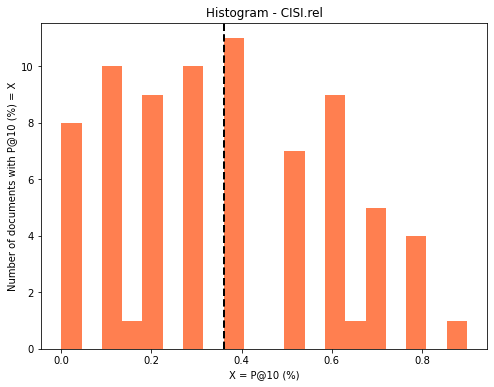

In [8]:
mean = sum(percentages)/len(percentages)
print("mean(P@10 [%]):", mean)

plt.figure(figsize=(8,6))
histogram = plt.hist(percentages, bins = 20, color='coral')

plt.axvline(mean, color='k', linestyle='dashed', linewidth=2)
plt.title('Histogram - CISI.rel')
plt.xlabel('X = P@10 (%)')
plt.ylabel('Number of documents with P@10 (%) = X')
plt.savefig('histograma.png', dpi=300, bbox_inches='tight')

plt.show()


### 5. Teste sua query na base CISI:

Para testar uma query da base de queries disponibilizada na CISI collection, basta inserir o índice da query no "query_id" e rodar a célula. Será impresso os 10 resultados mais relevantes calculados pelo algoritmo implementado e, também, os documentos relevantes identificados na base por quem fez a curadoria.

In [9]:
def get_doc_title(doc_id):
    return doc_set[doc_id]['title']

def get_docs_titles(list_doc_id):
    return [get_doc_title(_id) for _id in list_doc_id]

def add_doc_title_to_list_ids_scores(my_scores):
    ids, scores = zip(*my_scores)
    titles = get_docs_titles(list(ids))
    my_scores = zip(ids, scores, titles)
    return my_scores

In [10]:
query_id = 111

print(f'Os 10 documentos mais relevantes (com o score equivalente) identificados para a query id {query_id} são:')
my_scores = score_corpus(corpus, qry_set[111], k_1 = 1.2, b = 0.75)[0:10]
my_scores = add_doc_title_to_list_ids_scores(my_scores)
print(*my_scores, sep='\n')

print('----------------------')
print('Os documentos relevantes identificados para essa query são:')
if rel_set.get(query_id, -1) != -1:
    docs = rel_set.get(query_id)
    docs = [(_id, get_doc_title(_id)) for _id in docs]
    print(*docs, sep='\n')
else:
    print('Não há dados disponíveis para essa query')

Os 10 documentos mais relevantes (com o score equivalente) identificados para a query id 111 são:
(448, 69.00235899878709, 'An Evaluation of Query Expansion by the Addition of Clustered Terms for a Document Retrieval System .')
(570, 64.00533754562827, 'Deriving Term Relations for a Corpus by Graph Theoretical Clusters .')
(635, 63.137535659697505, 'Clustering of Scientific Journals .')
(566, 61.615747459936316, 'Semantic Clustering of Index Terms .')
(485, 61.366390599827135, 'A Clustering Experiment: First Step Towards a Computer-Generated Classification Scheme .')
(422, 56.3605499926944, 'On Some Clustering Techniques .')
(576, 56.13254186282193, 'Classification of Scientific Documents by Means of Self_Generated Groups Employing Free Language .')
(509, 49.72344676310337, 'The Use of Hierarchic Clustering in Information Retrieval .')
(483, 47.20112855265488, 'Performance of Automatic Information Systems .')
(608, 44.8691670777068, 'A new comparison Between Conventional Indexing (MEDL

Para testar uma query qualquer livre, altere o texto na variável query:

In [11]:
query = "What is information science?"

print(f'Query:\n{query}\n')
print('Os 10 documentos mais relevantes (com o score equivalente) identificados para a query são:')
my_scores = score_corpus(corpus, query, k_1 = 1.2, b = 0.75)[0:10]
my_scores = add_doc_title_to_list_ids_scores(my_scores)
print(*my_scores, sep='\n')

Query:
What is information science?

Os 10 documentos mais relevantes (com o score equivalente) identificados para a query são:
(469, 4.6850045903021105, 'The Phenomena of Interest to Information Science .')
(599, 4.601394271730624, 'On the Evaluation of Information Science .')
(85, 4.478923984123183, 'Information Science: Toward the Development of a True Scientific Discipline .')
(456, 4.449363096440866, 'Information and Its User .')
(60, 4.43299731910439, 'Information Science: What Is It? .')
(640, 4.41165880888777, 'The Scientific Premises of Information Science .')
(137, 4.316741649390238, 'Information Needs and Uses .')
(1181, 4.202782469743826, 'The Origins of the Information Crisis:  A Contribution to the Statement of the Problem .')
(1297, 4.155459275921286, 'Communication in the Physical and Social Sciences .')
(537, 4.152904241014136, 'The Information Sciences .')


### 6. Usando o ChatGPT

#### 6.1 Caso de teste gerado pelo ChatGPT:

[Nesta conversa](./conversa_chat_gpt_gerar_casos_teste.txt), solicitei uma lista fictícia de 10 documentos e 5 queries que eu poderia usar para testar o algoritmo. Em seguida, solicitei quais os documentos relevantes para cada query. A célula abaixo simplesmente coloca os documentos/queries no formato do algoritmo implementado e compara o resultado dado pela implementação com o resultado indicado pelo ChatGPT.

Apesar da lista de resultados sugerida ser diferente do resultado obtido, o primeiro documento indicado como mais relevante pelo ChatGPT foi o mesmo que o indicado pelo algoritmo implementado.

In [12]:
def get_doc_entry(title, text):
    return {
        "title": title,
        "text": text,
        "all": f"{title} {text}"
    }

chat_gpt_doc_set = {}
chat_gpt_doc_set[1] = get_doc_entry("The Benefits of Regular Exercise", "Regular exercise has been shown to have many benefits for both physical and mental health. It can help you maintain a healthy weight, reduce your risk of chronic diseases like heart disease and diabetes, and improve your mood and cognitive function.")
chat_gpt_doc_set[2] = get_doc_entry("How to Build a Birdhouse", "Building a birdhouse is a fun and rewarding project that can be completed in just a few hours. All you need is some basic woodworking tools and materials, and you'll have a cozy home for your feathered friends in no time.")
chat_gpt_doc_set[3] = get_doc_entry("The History of the Internet", "The internet has revolutionized the way we live, work, and communicate. But where did it all begin? In this article, we'll take a look at the history of the internet, from its humble beginnings as a military communication tool to the ubiquitous global network we know today.")
chat_gpt_doc_set[4] = get_doc_entry("5 Easy Vegetarian Recipes", "Eating a vegetarian diet has many health benefits, but it can be challenging to find delicious and satisfying meals. Here are five easy vegetarian recipes that are sure to please even the most dedicated carnivore.")
chat_gpt_doc_set[5] = get_doc_entry("The Basics of Investing", "Investing your money wisely is essential for long-term financial success. But where do you begin? In this article, we'll cover the basics of investing, including stocks, bonds, and mutual funds, so you can make informed decisions about your money.")
chat_gpt_doc_set[6] = get_doc_entry("The Top 10 Tourist Attractions in Paris", "Paris is one of the most popular tourist destinations in the world, and with good reason. From the Eiffel Tower to the Louvre Museum, there's no shortage of amazing sights to see in the City of Light. Here are the top 10 tourist attractions in Paris.")
chat_gpt_doc_set[7] = get_doc_entry("The Benefits of Meditation", "Meditation has been practiced for thousands of years, and for good reason. It can reduce stress and anxiety, improve sleep, and even lower blood pressure. In this article, we'll explore the benefits of meditation and how you can get started with your own practice.")
chat_gpt_doc_set[8] = get_doc_entry("The Rise of E-Commerce", "Online shopping has become a global phenomenon, with more and more people turning to e-commerce for their shopping needs. In this article, we'll look at the rise of e-commerce and the ways it's changing the retail industry.")
chat_gpt_doc_set[9] = get_doc_entry("10 Tips for Better Sleep", "Getting a good night's sleep is essential for physical and mental health, but it's not always easy. If you're struggling to get the rest you need, try these 10 tips for better sleep.")
chat_gpt_doc_set[10] = get_doc_entry("How to Make the Perfect Cup of Coffee", "For coffee lovers, there's nothing better than a perfectly brewed cup of joe. But what's the secret to making the perfect cup? In this article, we'll walk you through the steps to brewing the perfect cup of coffee.")

def get_query_entry(query, relevant_docs):
    return {"query": query, "relevant_docs": relevant_docs}

chat_gpt_queries = {}
chat_gpt_queries[1] = get_query_entry("How do I build a birdhouse?", [2, 10, 1, 5, 9, 8, 7, 6, 4, 3])
chat_gpt_queries[2] = get_query_entry("What are the benefits of regular exercise?", [1, 7, 5, 4, 9, 2, 6, 10, 8, 3])
chat_gpt_queries[3] = get_query_entry("What are the top tourist attractions in Paris?", [6, 5, 1, 7, 4, 9, 8, 3, 2, 10])
chat_gpt_queries[4] = get_query_entry("How do I invest my money?", [5, 7, 1, 9, 6, 2, 8, 4, 10, 3])
# O ChatGPT só trouxe os oito primeiros. Então coloquei os dois que restaram nas últimas posições aqui
chat_gpt_queries[5] = get_query_entry("What are some easy vegetarian recipes?", [4, 1, 7, 9, 5, 2, 6, 8, 3, 10])

corpus_chat_gpt = Corpus(chat_gpt_doc_set)

for id, query in chat_gpt_queries.items():
    text_query = query['query']
    chat_gpt_relevant_docs = query['relevant_docs']
    
    chat_gpt_id_score = score_corpus(corpus_chat_gpt, text_query, k_1 = 1.2, b = 0.75, use_stemmer = True)
    id_doc, score = zip(*chat_gpt_id_score)

    print(f"Query: {text_query}")
    for i in range(0, len(id_doc)):
        id_my_doc = id_doc[i]
        id_chat_gpt_doc = chat_gpt_relevant_docs[i]
        
        print(f"\tImplementation\t{ id_my_doc }: \t{chat_gpt_doc_set[id_my_doc]['title']}")
        print(f"\tChat GPT\t{ id_chat_gpt_doc }: \t{chat_gpt_doc_set[id_chat_gpt_doc]['title']}")
        print('')
        

    print('-------------------------------------')

Query: How do I build a birdhouse?
	Implementation	2: 	How to Build a Birdhouse
	Chat GPT	2: 	How to Build a Birdhouse

	Implementation	1: 	The Benefits of Regular Exercise
	Chat GPT	10: 	How to Make the Perfect Cup of Coffee

	Implementation	3: 	The History of the Internet
	Chat GPT	1: 	The Benefits of Regular Exercise

	Implementation	4: 	5 Easy Vegetarian Recipes
	Chat GPT	5: 	The Basics of Investing

	Implementation	5: 	The Basics of Investing
	Chat GPT	9: 	10 Tips for Better Sleep

	Implementation	6: 	The Top 10 Tourist Attractions in Paris
	Chat GPT	8: 	The Rise of E-Commerce

	Implementation	7: 	The Benefits of Meditation
	Chat GPT	7: 	The Benefits of Meditation

	Implementation	8: 	The Rise of E-Commerce
	Chat GPT	6: 	The Top 10 Tourist Attractions in Paris

	Implementation	9: 	10 Tips for Better Sleep
	Chat GPT	4: 	5 Easy Vegetarian Recipes

	Implementation	10: 	How to Make the Perfect Cup of Coffee
	Chat GPT	3: 	The History of the Internet

-----------------------------------

#### 6.2 Implementação do algoritmo pelo ChatGPT


[Nesta conversa](./conversa_chat_gpt_gerar_algoritmo.txt) solicitei a implementação de um algoritmo, o que foi fornecido pelo ChatGPT:

In [13]:
import math

class BM25:
    def __init__(self, documents, k1=1.5, b=0.75):
        self.documents = documents
        self.k1 = k1
        self.b = b
        self.avgdl = sum(len(d) for d in documents) / len(documents)
        self.idf = {}
        self.doc_freq = {}
        self.initialize()

    def initialize(self):
        for document in self.documents:
            for term in set(document):
                if term not in self.doc_freq:
                    self.doc_freq[term] = 0
                self.doc_freq[term] += 1

        for term, freq in self.doc_freq.items():
            self.idf[term] = math.log((len(self.documents) - freq + 0.5) / (freq + 0.5))

    def score(self, query, index):
        score = 0
        doc = self.documents[index]
        doc_len = len(doc)
        for term in query:
            if term not in self.idf:
                continue
            tf = doc.count(term)
            score += (self.idf[term] * tf * (self.k1 + 1)) / (tf + self.k1 * (1 - self.b + self.b * (doc_len / self.avgdl)))
        return score

    def get_scores(self, query):
        scores = []
        for i in range(len(self.documents)):
            score = self.score(query, i)
            scores.append((i, score))
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores


Após a explicação de como usar o algoritmo, podemos aplicá-lo a base CISI e, inicialmente, testar a implementação do ChatGPT com a minha usando uma query específica (id da query: 111) e mesmos parâmetros (k_1 = 1.2 e b = 0.75):

In [14]:
documents_for_bm25_chatgpt = []

for i in range(1, len(doc_set) + 1):
    documents_for_bm25_chatgpt.append(get_list_words(doc_set[i]['all']))
    
bm25 = BM25(documents_for_bm25_chatgpt, 1.2, 0.75)

In [15]:
query_id = 111

print(f'Os 10 primeiros resultados para a query id {query_id}:')
my_scores = score_corpus(corpus, qry_set[111], k_1 = 1.2, b = 0.75)[0:10]
print(*my_scores, sep='\n')
print('----------------------')

print(f'Os 10 primeiros resultados para a query id {query_id} de acordo com a implementação do Chat GPT:')
query = get_list_words(qry_set[111])
scores = bm25.get_scores(query)
scores = scores[0:10]

for index, score in scores:
    # The indexes in the implementation of ChatGPT starts at 0. In the CISI collection, at 1
    print(f"Document {index + 1}: {score}")

print('----------------------')
print('Os documentos relevantes identificados para essa query são:')
if rel_set.get(query_id, -1) != -1:
    print(*rel_set[query_id], sep='\n')
else:
    print('Não há dados disponíveis para essa query')

Os 10 primeiros resultados para a query id 111:
(448, 69.00235899878709)
(570, 64.00533754562827)
(635, 63.137535659697505)
(566, 61.615747459936316)
(485, 61.366390599827135)
(422, 56.3605499926944)
(576, 56.13254186282193)
(509, 49.72344676310337)
(483, 47.20112855265488)
(608, 44.8691670777068)
----------------------
Os 10 primeiros resultados para a query id 111 de acordo com a implementação do Chat GPT:
Document 448: 62.11190942915783
Document 570: 61.358368942879075
Document 635: 57.10510292584185
Document 485: 56.28145345633532
Document 566: 55.407889328538026
Document 422: 50.75734726295538
Document 576: 50.38227137934702
Document 509: 43.52151839928218
Document 483: 43.037698238534105
Document 608: 39.63068983936048
----------------------
Os documentos relevantes identificados para essa query são:
328
422
448
485
503
509


Podemos observar que, apesar dos resultados diferirem, eles são muito próximos do que foi implementado aqui. Tanto a ordem dos documentos retorada é parecida quanto o cálculo do score é muito parecido. Após inspeção e comparação dos dois códigos, podemos notar que a única diferença é no cálculo do IDF. Minha implementação usou a fórmula disponível na [Wikipedia](https://en.wikipedia.org/wiki/Okapi_BM25):

$$ IDF(q_i) = ln \left( \frac{N - n(q_i) + 0.5}{n(q_i) + 0.5} + 1\right) $$

A implementação do ChatGPT é equivalente a:

$$ IDF(q_i) = ln \left( \frac{N - n(q_i) + 0.5}{n(q_i) + 0.5}\right) $$

Se adicionarmos + 1 a implementação do ChatGPT ou removermos esse +1 da implementação feita aqui, o resultado passa a ser o mesmo.

Mas, em vez de ajustar essa diferença, vamos calcular o P@10 (%) na CISI collection e comparar os resultados da implementação do ChatGPT com a feita anteriormente:

In [16]:
# Get all ids that we have data to compare
queries_id = rel_set.keys()

results = []

for query_id in queries_id:
    # Retrieve the query
    query = get_list_words(qry_set[query_id])
    # Calculate the score for each document
    scores = bm25.get_scores(query)
    scores = scores[0:10]
    id_score_with_some_score = list(filter(lambda x: x[1] > 0, scores))
    # Calculate results
    chat_gpt_first_10_results, _ = zip(*id_score_with_some_score)
    # Documents id in the chatGPT starts at 0. In CISI collection, at 1. Correct this:
    chat_gpt_first_10_results = [_id + 1 for _id in chat_gpt_first_10_results]
    
    cisi_results = rel_set[query_id]
    
    intersection = set(chat_gpt_first_10_results).intersection(set(cisi_results))
    
    percentage = len(intersection)/min(10, len(cisi_results))
    
    result = (query_id, my_first_10_results, cisi_results, intersection, percentage)
    results.append(result)
    
#for result in results:
#    query_id, my_first_10_results, cisi_results, intersection, percentage = result
#    
#    print(query_id, percentage)
_, _, _, _, percentages_chat_gpt = list(zip(*results))

mean = sum(percentages_chat_gpt)/len(percentages_chat_gpt)
print("mean(P@10 [%]):", mean)

mean(P@10 [%]): 0.3519736842105264


mean(P@10 [%]): 0.3519736842105264


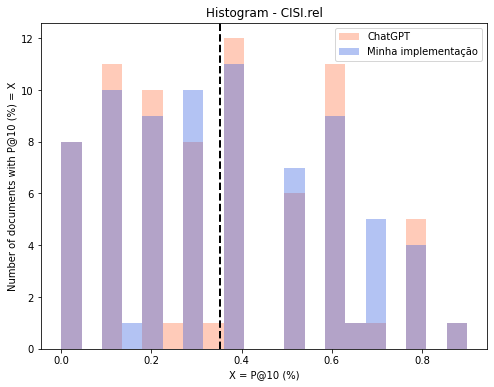

In [24]:
mean = sum(percentages_chat_gpt)/len(percentages_chat_gpt)
print("mean(P@10 [%]):", mean)

plt.figure(figsize=(8,6))
plt.hist(percentages_chat_gpt, alpha=0.4, bins = 20, color='coral', label='ChatGPT')
plt.hist(percentages, alpha=0.4, bins = 20, color='royalblue', label='Minha implementação')

plt.axvline(mean, color='k', linestyle='dashed', linewidth=2)
plt.title('Histogram - CISI.rel')
plt.xlabel('X = P@10 (%)')
plt.ylabel('Number of documents with P@10 (%) = X')
plt.legend(loc='upper right')
plt.savefig('histograma_chat_gpt_implementation.png', dpi=300, bbox_inches='tight')

plt.show()


Podemos ver aqui uma diferença de aproximadamente 1 ponto percentual, desfavorável para a implementação do ChatGPT. Ou seja, para essa base de dados e esses parâmetros (k_1 = 1.2 e b = 0.75), a formulação do IDF adicionando +1 ao parâmetro do log é mais interessante. Entretanto, não é possível generalizar essa conclusão para outras bases de dados e parâmetros.

### 7. Conclusões

Este trabalho foi desenvolvido para a pré-selecão da disciplina "Deep Learning aplicado a sistemas de buscas". Foi solicitado a implementação de um algoritmo BM25 e sua aplicação à coleção CISI. O uso do ChatGPT foi permitido e encorajado.

Como o objetivo final é o aprendizado de conceitos, foquei inicialmente no entendimento do BM25 e na sua implementação usando as fórmulas disponíveis na Wikipedia. Para o teste do algoritmo, foram feitos cálculos manuais comparando uma base de cinco documentos com frases simples. Em seguida, executei todas as queries disponibilizadas e comparei com os resultados esperados.

Após esse procedimento, o ChatGPT foi utilizado para gerar 10 documentos de testes fictícios em inglês. Além disso, o ChatGPT sugeriu 5 queries e apresentou a ordenação daqueles 10 documentos segundo as queries sugeridas. Nessa ocasião foi possível testar novamente o algoritmo, mas dessa vez com uma base de 10 documentos. Apesar da ordenação dos documentos ter sido bem diferentes, nos cinco casos analisados o primeiro documento retornado como mais relevante na implementação realizada foi o mesmo que o primeiro documento retornado como relevante pelo ChatGPT.

Por último, o ChatGPT foi utilizado para gerar um código de ranqueamento seguindo o BM25. Em seguida, testado com toda a coleção CISI. Os resultados foram muito semelhantes ao código implementado, diferindo apenas em relação à implementação do IDF: Enquanto o IDF implementado é ln(func(q_i) + 1), onde func(q_i) é uma função que depende da frequência do termo na coleção de documentos, o IDF sugerido pelo ChatGPT não possui o termo aditivo (+ 1). O efeito disso nessa base foi pequeno, reduzindo em 1 ponto percentual a métrica utilizada (equivalente a uma piora de menos de 3%).

Mais do que otimização de código, o objetivo final aqui é o aprendizado de conceitos. Por isso, optei por não focar demasiadamente na otimização do algoritmo implementado, nem em reduzir demais o código. Por isso, após a conclusão deste relatório foram identificadas algumas oportunidades de melhoria, o que poderia ser feito se o intuito fosse a implementação de uma versão final desse algoritmo para uso por outras pessoas. Apenas para enumerar algumas oportunidades de melhoria:

- Apesar de ter sido criada uma classe _Corpus_, ela foi utilizada apenas para o cálculo do IDF e algumas outras questões relacionadas ao documento. A implementação do BM25 em si foi feita por uma função auxiliar (_score_corpus_). Há diversas oportunidades de melhoria nessa organização do código como, por exemplo, a questão do pré-processamento dos documentos e das queries (do jeito que está o código hoje, o usuário pode esquecer de pré-processar a query da mesma forma que os documentos são pré-processados).

- Os parâmetros k_1 e b foram usados aqui com os valores de 1.2 e 0.75. Testei diversos valores e estes se mostraram mais adequados para essa base. Entretanto poderia ter sido feita uma busca mais intensa para a otimização desses parâmetros.

- Há diversos "sabores" do BM25 sendo que neste trabalho apenas uma versão foi implementada. Há oportunidade aqui também, outros modelos poderiam ser testados.

- O pré-processamento tem uma influência muito grande no resultado final, e as decisões aqui de pré-processamento do texto envolveram apenas a remoção manual de algumas stopwords e o uso do Porter Stemmer. Há diversas bases de stopwords que poderiam ser testadas, assim como também há outros stemmers que poderiam ser testados.

- Ainda em relação ao pré-processamento, há oportunidades de melhorias no tratamento de n-gramas e no peso das informações. Por exemplo, neste exercício o conteúdo do documento considerou apenas as tags author, abstract e title, ambas com pesos 1. Ao dar um peso 2 para o título há uma ligeira melhora nos resultados (< 0.5 p.p.).

- Além do P@10, há possibilidades de testar outras métricas, inclusive testando outros valores de k_1 e b para a otimização delas.